In [7]:
from scipy import optimize, constants, special
import numpy as np

In [ ]:
ne = 12e6
Te = 100
Ta = 12
Tp = 3
Vab = 100e3

ma = 4.0 * constants.proton_mass
mp = constants.proton_mass
me = constants.electron_mass

ve = np.sqrt(2 * constants.elementary_charge * Te / me)
va = np.sqrt(2 * constants.elementary_charge * Ta / ma)
vp = np.sqrt(2 * constants.elementary_charge * Tp / mp)

cs = ve / np.sqrt(2) * np.sqrt(me / mp) * (1 + 3 * Tp / Te)

wpe = np.sqrt(ne * constants.elementary_charge ** 2 / (me * constants.epsilon_0))
ld =  ve / (wpe * np.sqrt(2))

kvecld = np.arange(0.01, 1.5, 0.001)
kvec = kvecld / ld

wr1         = np.zeros_like(kvec)
wi1         = np.zeros_like(kvec)
dispreltemp = np.zeros_like(kvec)

nanprat = 10 ** np.arange(-3, 1, 0.05)

gammamax = np.zeros_like(nanprat)
kmax     = np.zeros_like(nanprat)
wmax     = np.zeros_like(nanprat)
wpparr   = np.zeros_like(nanprat)
wpaarr   = np.zeros_like(nanprat)
naarr    = np.zeros_like(nanprat)
nparr    = np.zeros_like(nanprat)

In [ ]:
for ratio_idx in range(len(nanprat)):
    # Define function
    n_p = 12e6 / (2 * nanprat[ratio_idx] + 1)
    n_a = (12e6 - n_p) / 2
    wpa = np.sqrt(n_a * 2 ** 2 * constants.elementary_charge ** 2 / (ma * constants.epsilon_0))
    wpp = np.sqrt(n_p * constants.elementary_charge ** 2 / (mp * constants.epsilon_0))
    wpparr[ratio_idx] = wpp
    wpaarr[ratio_idx] = wpa
    nparr[ratio_idx] = n_p
    naarr[ratio_idx] = n_a

    for k_idx in range(len(kvec)):
        xip = lambda omega : omega / (kvec[k_idx] * vp)
        xie = lambda omega: omega / (kvec[k_idx] * ve)
        xia = lambda omega: (omega - kvec[k_idx] * Vab) / (kvec[k_idx] * va)

        def disprel(omega):
            omega = omega[0] + 1j * omega[1]
            result = 1 + 2 * wpp ** 2 / (kvec[k_idx] ** 2 * vp ** 2) * \
                (1 + 1j * np.sqrt(np.pi) * xip(omega) * special.wofz(xip(omega))) + \
                + 2 * wpe ** 2 / (kvec[k_idx] ** 2 * ve ** 2) * (1 + 1j * np.sqrt(np.pi) * xie(omega) * special.wofz(xie(omega))) + \
                + 2 * wpa ** 2 / (kvec[k_idx] ** 2 * va ** 2) * (1 + 1j * np.sqrt(np.pi) * xia(omega) * special.wofz(xia(omega)))
            return [np.real(result), np.imag(result)]

        if ratio_idx < 2:
            if k_idx < 5:
                guessw1 = cs * kvec[k_idx] / 5
            else:
                guessw1 = wr1[k_idx-1] + 1j * wi1[k_idx-1]
        else:
            if k_idx < 5:
                guessw1 = dispreltemp[k_idx]
            else:
                guessw1 = wr1[k_idx-1] + 1j * wi1[k_idx-1]

        x = optimize.fsolve(disprel, x0=[np.real(guessw1), np.imag(guessw1)], xtol=1e-12)

        # [~,maxpos] = max(x);
        wr1[k_idx] = x[0]
        wi1[k_idx] = x[1]

    dispreltemp = wr1 + 1j * wi1

    wmaxtemp = np.max(wi1)
    idxgam = np.argmax(wi1)
    if wmaxtemp < 0:
        gammamax[ratio_idx] = np.nan
        kmax[ratio_idx] = np.nan
        wmax[ratio_idx] = np.nan
    else:
        gammamax[ratio_idx] = wi1[idxgam]
        kmax[ratio_idx] = kvec[idxgam]
        wmax[ratio_idx] = wr1[idxgam]

/tmp/ipykernel_1043023/3073031687.py:36: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x = optimize.fsolve(disprel, x0=[np.real(guessw1), np.imag(guessw1)], xtol=1e-12)
/tmp/ipykernel_1043023/3073031687.py:36: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x = optimize.fsolve(disprel, x0=[np.real(guessw1), np.imag(guessw1)], xtol=1e-12)
/tmp/ipykernel_1043023/3073031687.py:20: RuntimeWarning: invalid value encountered in scalar multiply
  (1 + 1j * np.sqrt(np.pi) * xip(omega) * special.wofz(xip(omega))) + \
/tmp/ipykernel_1043023/3073031687.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  result = 1 + 2 * wpp ** 2 / (kvec[k_idx] ** 2 * vp ** 2) * \
/tmp/ipykernel_1043023/3073031687.py:21: RuntimeWarning: invalid value encountered in scalar multiply
  + 2 * wpe ** 2 / (kvec[k_idx] ** 2 * ve ** 2) * (1 +

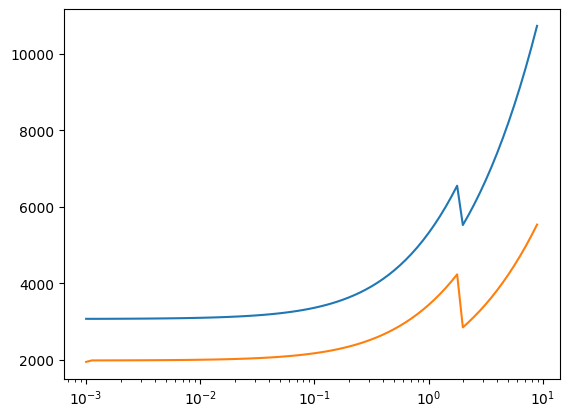

In [19]:
import matplotlib.pyplot as plt
plt.plot(nanprat, np.abs(wmax /wpparr))
# plt.plot(nanprat, np.abs(kmax*ld))
plt.plot(nanprat, np.abs(gammamax / wpparr))
plt.xscale("log")
plt.show()
# semilogx(nanprat,gammamax./wpparr,nanprat,wmax./wpparr,nanprat,kmax*ld,'linewidth',2)